### Import Libraries

In [1]:
# for Data manipulation and analysis
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
sns.set_style('darkgrid')

# Silhouette analysis
from sklearn.metrics import silhouette_score

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# for scaling
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install openpyxl

In [3]:
!pip install xlrd

In [4]:
## load the DataSet
df = pd.read_excel('RetailPulseAssignmentData.xlsx')

In [5]:
## random 5 values
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
34515,492285,21770,OPEN CLOSED METAL SIGN,4,2009-12-16 11:45:00,4.95,13097.0,United Kingdom
43916,493260,22099,CARAVAN SQUARE TISSUE BOX,1,2009-12-22 14:31:00,2.57,NaN,United Kingdom
24218,491403,22296,HEART IVORY TRELLIS LARGE,12,2009-12-10 17:27:00,1.65,14030.0,United Kingdom
522840,537915,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-09 10:55:00,9.95,12797.0,Portugal
350004,C523396,84946,ANTIQUE SILVER TEA GLASS ETCHED,-2,2010-09-21 20:13:00,1.25,13555.0,United Kingdom


In [6]:
## check the shape of the DataSet
df.shape

(525461, 8)

In [7]:
# looking at the overall picture
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [8]:
## description of all 
df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


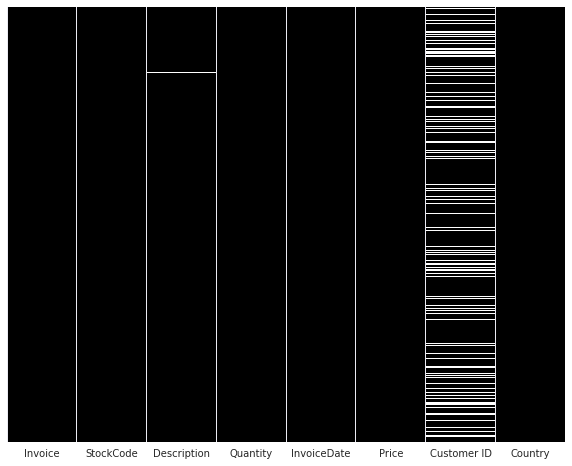

In [9]:
plt.subplots(figsize=(10, 8))
sns.heatmap(df.isnull(), yticklabels = False,cbar = False, cmap='cubehelix')
plt.show()

In [10]:
# checking the number of missing values in each column
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

## Data Cleaning

In [11]:
# count of duplicated rows in the data
df.duplicated().sum()

6865

In [12]:
# removing the duplicate rows
df = df[~df.duplicated()]
df.shape

(518596, 8)

## Features:
### Invoice

In [13]:
# these are the transactions that have negative quantity which indicates returned or cancelled orders
df[df['Invoice'].str.startswith('C')==True]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


In [14]:
# removing all the invoice number who starts with 'C' as they are returned orders
df = df[df['Invoice'].str.startswith('C')!=True]
df.shape

(508414, 8)

In [15]:
# checking the number of unique transactions
# though there are more than 5 lakh entries but the number of transaction happened is 21892
df.Invoice.nunique()

24224

### StockCode

In [16]:
# checking the unique stock ids in the data or number of unqiue item sold by retailer
df.StockCode.nunique()

4627

In [17]:
# top 10 stock ids that sold the most
df.StockCode.value_counts().head(10)

85123A    3377
22423     2045
85099B    2003
21212     1887
21232     1679
20725     1558
84879     1437
84991     1372
21754     1349
20914     1207
Name: StockCode, dtype: int64

In [18]:
# looking at the distribution of the quantity
# we seen that there is negative value which might indicate return orders
df.Quantity.describe()

count    508414.000000
mean         11.066713
std         105.046657
min       -9600.000000
25%           1.000000
50%           3.000000
75%          12.000000
max       19152.000000
Name: Quantity, dtype: float64

In [19]:
# looking at the data where quantity is negative and possible explanation is these are return orders or cancelled order
df[df['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524458,538092,37467,NaN,-177,2010-12-09 14:49:00,0.0,NaN,United Kingdom
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.0,NaN,United Kingdom


In [20]:
# keeping only those transactions that have successfully ordered
df = df[df['Quantity']>=0]
df.shape

(506293, 8)

### InvoiceDate

In [21]:
print('The minimum date is:',df.InvoiceDate.min())
print('The maximum date is:',df.InvoiceDate.max())

The minimum date is: 2009-12-01 07:45:00
The maximum date is: 2010-12-09 20:01:00


In [22]:
# checking the distribution of unit price
df.Price.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    506293.000000
mean          3.991056
std         128.813062
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
90%           7.950000
95%          10.000000
99%          19.950000
max       25111.090000
Name: Price, dtype: float64

### Country

In [23]:
# we see that more than 90% have country as UK which is obvious as the retailer is UK based
df.Country.value_counts(normalize=True)

United Kingdom          0.924672
EIRE                    0.018667
Germany                 0.015114
France                  0.010891
Netherlands             0.005390
Spain                   0.002425
Switzerland             0.002311
Portugal                0.002090
Belgium                 0.002048
Sweden                  0.001750
Channel Islands         0.001622
Italy                   0.001398
Australia               0.001244
Cyprus                  0.001053
Austria                 0.001035
Greece                  0.001011
Denmark                 0.000826
United Arab Emirates    0.000788
Norway                  0.000721
Finland                 0.000685
Unspecified             0.000604
USA                     0.000454
Poland                  0.000359
Malta                   0.000336
Japan                   0.000324
Lithuania               0.000304
Singapore               0.000231
RSA                     0.000217
Bahrain                 0.000209
Canada                  0.000152
Thailand  

In [24]:
# putting UK as one country and combine rest countries into one category
df['Country'] = df['Country'].apply(lambda x:'United Kingdom' if x=='United Kingdom' else 'Others')
df.Country.value_counts(normalize=True)

United Kingdom    0.924672
Others            0.075328
Name: Country, dtype: float64

### Description

In [25]:
# checking the number of unique item list
df.Description.nunique()

4560

In [26]:
# top 10 item sold
df.Description.value_counts().head(10)

WHITE HANGING HEART T-LIGHT HOLDER    3410
REGENCY CAKESTAND 3 TIER              2036
STRAWBERRY CERAMIC TRINKET BOX        1679
ASSORTED COLOUR BIRD ORNAMENT         1436
PACK OF 72 RETRO SPOT CAKE CASES      1435
60 TEATIME FAIRY CAKE CASES           1372
HOME BUILDING BLOCK WORD              1349
JUMBO BAG RED RETROSPOT               1271
LUNCH BAG RED SPOTTY                  1231
JUMBO STORAGE BAG SUKI                1194
Name: Description, dtype: int64

In [27]:
# there are cases where the descriptions contains some code/name which are not directly refers to sales
# checking the data where description = ? and it is noted that customerid is NaN and unit price is 0
df[df['Description'].str.startswith('?')==True]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
63439,495027,21314,?,1146,2010-01-20 13:48:00,0.0,NaN,United Kingdom
307123,519373,21900,?,1520,2010-08-16 13:28:00,0.0,NaN,United Kingdom
309842,519608,48188,?,106,2010-08-18 16:25:00,0.0,NaN,United Kingdom
451858,532332,84944,?sold individually?,486,2010-11-11 15:43:00,0.0,NaN,United Kingdom


In [28]:
# removing all the above entries
df = df[df['Description'].str.startswith('?')!=True]
df.shape

(506289, 8)

In [29]:
# checking the data where description = * and it is noted that customerid is NaN
df[df['Description'].str.startswith('*')==True]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1898,489597,20739,*USB Office Glitter Lamp,1,2009-12-01 14:28:00,8.65,NaN,United Kingdom
5374,489856,20954,*USB Office Mirror Ball,1,2009-12-02 14:36:00,8.65,NaN,United Kingdom
523687,538071,21120,*Boombox Ipod Classic,1,2010-12-09 14:09:00,16.98,NaN,United Kingdom


In [30]:
# replacing with appropriate name
df['Description'] = df['Description'].replace(('*Boombox Ipod Classic','*USB Office Mirror Ball'),
                                             ('BOOMBOX IPOD CLASSIC','USB OFFICE MIRROR BALL'))

In [31]:
# Description have actual entries in uppercase words and those who don't have are some of the noises in the dataset
df[df['Description'].str.islower()==True]['Description'].value_counts()

temp                           4
checked                        3
amazon                         3
mailout                        3
found                          3
amendment                      2
update                         2
amazon adjustment              2
damaged                        2
debenhams                      1
tk maxx mix up with pink       1
found again                    1
eurobargain invc/credit        1
correct previous adjustment    1
wrong invc                     1
dotcom email                   1
mailout addition               1
Name: Description, dtype: int64

In [32]:
# removing all the above noises
df = df[df['Description'].str.islower()!=True]
df.shape

(506257, 8)

In [33]:
# Description have actual entries in uppercase words and those who don't have are some of the noises in the dataset
df[df['Description'].str.istitle()==True]['Description'].value_counts()


Manual                                555
Bank Charges                           21
Dotcomgiftshop Gift Voucher £30.00     17
Dotcomgiftshop Gift Voucher £20.00     17
Hypochondriac Pill Stress Ball          9
Dotcomgiftshop Gift Voucher £10.00      6
Electronic Talking Breath-A-Loser       5
Discount                                5
Glow In The Dark Shot Glasses           3
Dotcomgiftshop Gift Voucher £50.00      2
Dotcomgiftshop Gift Voucher £40.00      2
 Bank Charges                           2
Mailout                                 2
Dotcomgiftshop Gift Voucher £80.00      1
Dotcomgiftshop Gift Voucher £70.00      1
Found                                   1
Name: Description, dtype: int64

In [34]:
# removing all the above listed noises
df = df[df['Description'].str.istitle()!=True]
df.shape

(505608, 8)

In [35]:
df['Description'] = df['Description'].str.strip()

### CustomerID

In [36]:
# count of unique customer
df["Customer ID"].nunique() 

4300

In [37]:
# checking where customer id is null
df[df["Customer ID"].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525144,538154,84029E,RED WOOLLY HOTTIE WHITE HEART.,5,2010-12-09 16:35:00,8.47,NaN,United Kingdom
525145,538154,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2010-12-09 16:35:00,8.47,NaN,United Kingdom
525146,538154,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-09 16:35:00,4.21,NaN,United Kingdom
525147,538154,DOT,DOTCOM POSTAGE,1,2010-12-09 16:35:00,85.79,NaN,United Kingdom


In [38]:
# removing entries where customer id is null
df = df[~df["Customer ID"].isnull()]
df.shape

(400501, 8)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400501 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400501 non-null  object        
 1   StockCode    400501 non-null  object        
 2   Description  400501 non-null  object        
 3   Quantity     400501 non-null  int64         
 4   InvoiceDate  400501 non-null  datetime64[ns]
 5   Price        400501 non-null  float64       
 6   Customer ID  400501 non-null  float64       
 7   Country      400501 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.5+ MB


In [40]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

### There is no Null value. 

In [41]:
# checking random 5 rows from data
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
488996,535257,21755,LOVE BUILDING BLOCK WORD,2,2010-11-25 13:13:00,5.95,15044.0,United Kingdom
242303,512808,37476,CONDIMENT TRAY 4 BOWLS AND 4 SPOONS,1,2010-06-18 11:23:00,9.95,16155.0,United Kingdom
284010,516964,22384,LUNCH BAG PINK RETROSPOT,10,2010-07-26 09:12:00,1.65,16210.0,United Kingdom
172061,505709,21100,CHARLIE AND LOLA CHARLOTTE BAG,2,2010-04-25 12:34:00,1.65,13050.0,United Kingdom
374985,525571,22689,DOORMAT MERRY CHRISTMAS RED,2,2010-10-06 10:04:00,7.95,13707.0,United Kingdom


## **EDA** 

In [42]:
# creating some columns for exploratory

df['Amount'] = df['Quantity']*df['Price']
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.month
df['day'] = df['InvoiceDate'].dt.day
df['hour'] = df['InvoiceDate'].dt.hour
df['day_of_week'] = df['InvoiceDate'].dt.dayofweek

In [43]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,year,month,day,hour,day_of_week
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,1,7,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,7,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,7,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,1,7,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,1,7,1


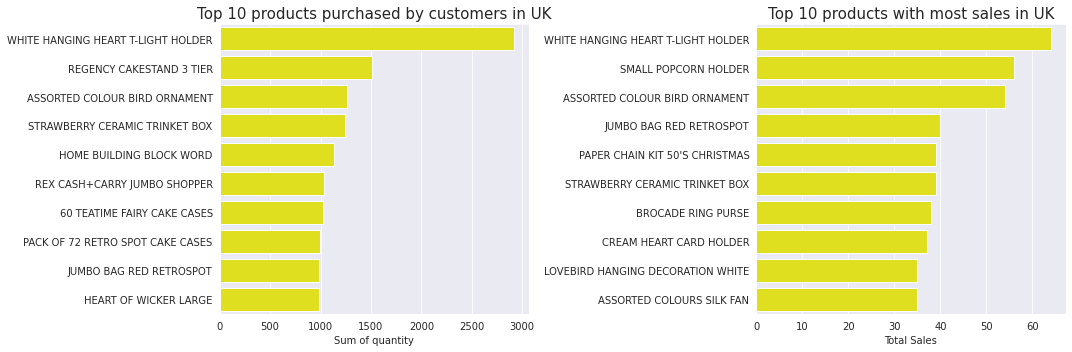

In [44]:
column = ['Invoice','Amount']

plt.figure(figsize=(15,5))
for i,j in enumerate(column):
    plt.subplot(1,2,i+1)
    sns.barplot(x = df[df['Country']=='United Kingdom'].groupby('Description')[j].nunique().sort_values(ascending=False).head(10).values,
                y = df[df['Country']=='United Kingdom'].groupby('Description')[j].nunique().sort_values(ascending=False).head(10).index,
                color='yellow')
    plt.ylabel('')
    if i==0:
        plt.xlabel('Sum of quantity')
        plt.title('Top 10 products purchased by customers in UK',size=15)
    else:
        plt.xlabel('Total Sales')
        plt.title('Top 10 products with most sales in UK',size=15)
        
plt.tight_layout()
plt.show()

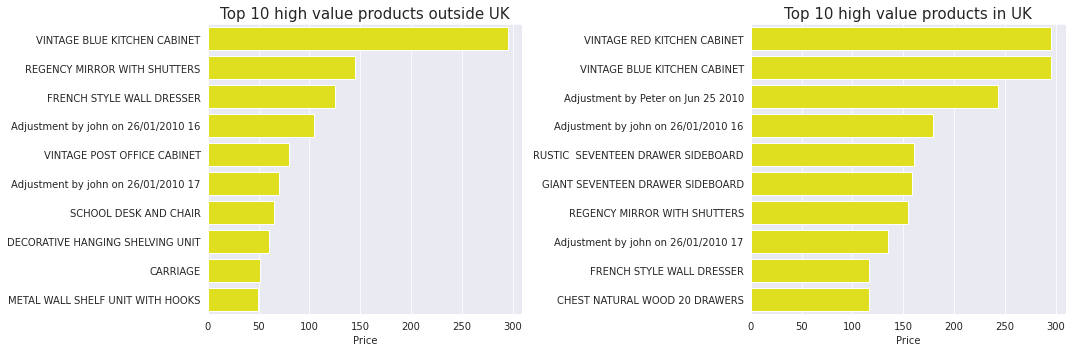

In [45]:
column = ['Others','United Kingdom']

plt.figure(figsize=(15,5))
for i,j in enumerate(column):
    plt.subplot(1,2,i+1)
    sns.barplot(x = df[df['Country']==j].groupby('Description')['Price'].mean().sort_values(ascending=False).head(10).values,
                y = df[df['Country']==j].groupby('Description')['Price'].mean().sort_values(ascending=False).head(10).index,
                color='yellow')
    plt.ylabel('')
    if i==0:
        plt.xlabel('Price')
        plt.title('Top 10 high value products outside UK',size=15)
    else:
        plt.xlabel('Price')
        plt.title('Top 10 high value products in UK',size=15)
        
plt.tight_layout()
plt.show()

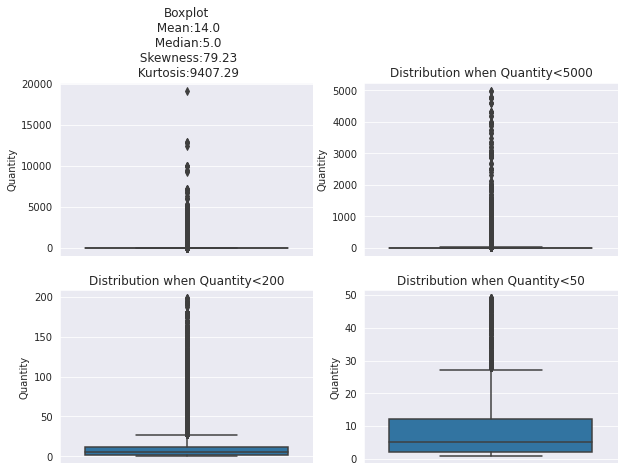

In [46]:
# Looking the distribution of column Quantity
plt.figure(figsize=(10,7))

skewness = round(df.Quantity.skew(),2)
kurtosis = round(df.Quantity.kurtosis(),2)
mean = round(np.mean(df.Quantity),0)
median = np.median(df.Quantity)

plt.subplot(2,2,1)
sns.boxplot(y=df.Quantity)
plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.subplot(2,2,2)
sns.boxplot(y=df[df.Quantity<5000]['Quantity'])
plt.title('Distribution when Quantity<5000')

plt.subplot(2,2,3)
sns.boxplot(y=df[df.Quantity<200]['Quantity'])
plt.title('Distribution when Quantity<200')

plt.subplot(2,2,4)
sns.boxplot(y=df[df.Quantity<50]['Quantity'])
plt.title('Distribution when Quantity<50')

plt.show()


In [47]:
# removing the expectional case where quantity > 70000
df = df[df['Quantity']<70000]

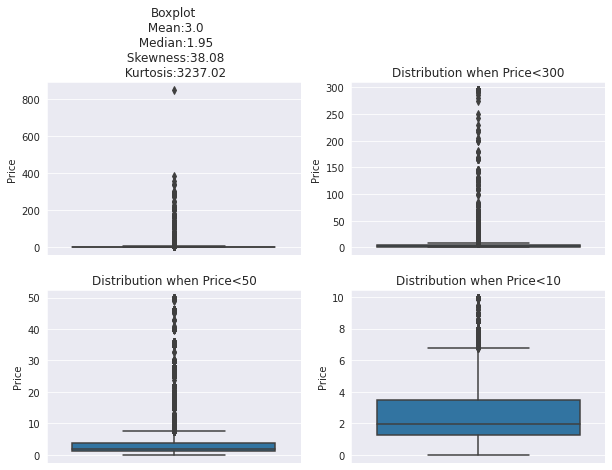

In [48]:
# Looking the distribution of column Unit Price
plt.figure(figsize=(10,7))

skewness = round(df.Price.skew(),2)
kurtosis = round(df.Price.kurtosis(),2)
mean = round(np.mean(df.Price),0)
median = np.median(df.Price)

plt.subplot(2,2,1)
sns.boxplot(y=df.Price)
plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.subplot(2,2,2)
sns.boxplot(y=df[df.Price<300]['Price'])
plt.title('Distribution when Price<300')

plt.subplot(2,2,3)
sns.boxplot(y=df[df.Price<50]['Price'])
plt.title('Distribution when Price<50')

plt.subplot(2,2,4)
sns.boxplot(y=df[df.Price<10]['Price'])
plt.title('Distribution when Price<10')

plt.show()

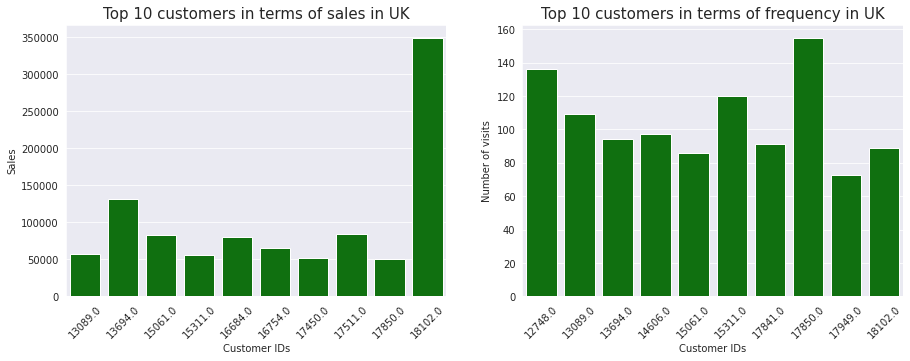

In [49]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(y = df[df['Country']=='United Kingdom'].groupby('Customer ID')['Amount'].sum().sort_values(ascending=False).head(10).values,
            x = df[df['Country']=='United Kingdom'].groupby('Customer ID')['Amount'].sum().sort_values(ascending=False).head(10).index, 
            color='green')
plt.ylabel('Sales')
plt.xlabel('Customer IDs')
plt.xticks(rotation=45)
plt.title('Top 10 customers in terms of sales in UK',size=15)

plt.subplot(1,2,2)
sns.barplot(y = df[df['Country']=='United Kingdom'].groupby('Customer ID')['Invoice'].nunique().sort_values(ascending=False).head(10).values,
            x = df[df['Country']=='United Kingdom'].groupby('Customer ID')['Invoice'].nunique().sort_values(ascending=False).head(10).index, 
            color='green')
plt.ylabel('Number of visits')
plt.xlabel('Customer IDs')
plt.xticks(rotation=45)
plt.title('Top 10 customers in terms of frequency in UK',size=15)

plt.show()

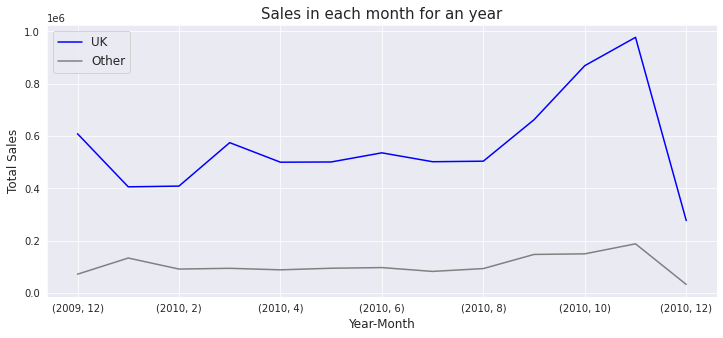

In [50]:
plt.figure(figsize=(12,5))
df[df['Country']=='United Kingdom'].groupby(['year','month'])['Amount'].sum().plot(kind='line',label='UK',color='blue')
df[df['Country']=='Others'].groupby(['year','month'])['Amount'].sum().plot(kind='line',label='Other',color='grey')
plt.xlabel('Year-Month',size=12)
plt.ylabel('Total Sales', size=12)
plt.title('Sales in each month for an year', size=15)
plt.legend(fontsize=12)
plt.show()

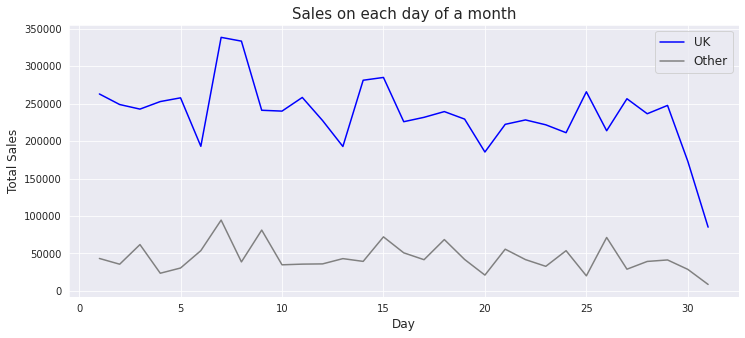

In [51]:
plt.figure(figsize=(12,5))
df[df['Country']=='United Kingdom'].groupby(['day'])['Amount'].sum().plot(kind='line',label='UK',color='blue')
df[df['Country']=='Others'].groupby(['day'])['Amount'].sum().plot(kind='line',label='Other',color='grey')
plt.xlabel('Day',size=12)
plt.ylabel('Total Sales', size=12)
plt.title('Sales on each day of a month', size=15)
plt.legend(fontsize=12)
plt.show()

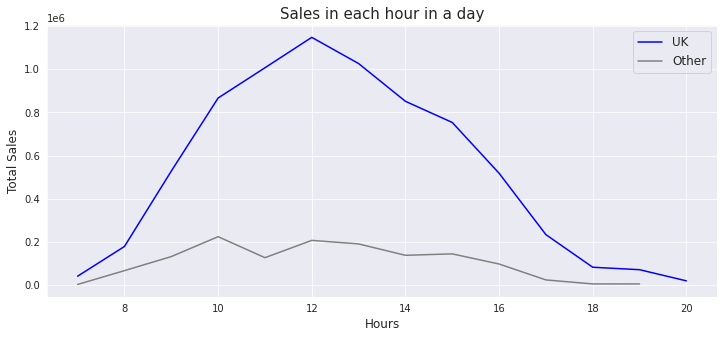

In [52]:
plt.figure(figsize=(12,5))
df[df['Country']=='United Kingdom'].groupby(['hour'])['Amount'].sum().plot(kind='line',label='UK',color='blue')
df[df['Country']=='Others'].groupby(['hour'])['Amount'].sum().plot(kind='line',label='Other',color='grey')
plt.xlabel('Hours',size=12)
plt.ylabel('Total Sales', size=12)
plt.title('Sales in each hour in a day', size=15)
plt.legend(fontsize=12)
plt.show()

### 1. Cohort Analysis

In [53]:
# copying the data into new df
df_cohort = df.copy()
# select only limited columns
df_cohort = df_cohort.iloc[:,:9]
df_cohort.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


For cohort analysis, there are a few labels that we have to create:

* Invoice Month: A string representation of the year and month of a single transaction/invoice.

* Cohort Month: A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.

* Cohort period: A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.





In [54]:
# creating the first variable 'Invoice Month'
# extracting only year-month from Invoice Date and day will be 1 automatically

df_cohort['InvoiceMonth'] = df_cohort['InvoiceDate'].dt.strftime('%Y-%m')
# converting the variable to datetime format
df_cohort['InvoiceMonth'] = pd.to_datetime(df_cohort['InvoiceMonth'])

In [55]:
# creating the second variable 'Cohort Month'
# getting the first time purchase date for each customer

df_cohort['CohortMonth'] = df_cohort.groupby('Customer ID')['InvoiceMonth'].transform('min')
# converting the variable to datetime format
df_cohort['CohortMonth'] = pd.to_datetime(df_cohort['CohortMonth'])

In [56]:
df_cohort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400501 entries, 0 to 525460
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice       400501 non-null  object        
 1   StockCode     400501 non-null  object        
 2   Description   400501 non-null  object        
 3   Quantity      400501 non-null  int64         
 4   InvoiceDate   400501 non-null  datetime64[ns]
 5   Price         400501 non-null  float64       
 6   Customer ID   400501 non-null  float64       
 7   Country       400501 non-null  object        
 8   Amount        400501 non-null  float64       
 9   InvoiceMonth  400501 non-null  datetime64[ns]
 10  CohortMonth   400501 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(3), int64(1), object(4)
memory usage: 36.7+ MB


In [57]:
# creating the third variable 'Cohort Period'
# for this we create a function which calculates the number of month between their first purchase date and Invoice date

def diff_month(d1, d2):
    return((d1.dt.year - d2.dt.year) * 12 + d1.dt.month - d2.dt.month)

df_cohort['CohortPeriod'] = diff_month(df_cohort['InvoiceMonth'], df_cohort['CohortMonth'])

In [58]:
df_cohort.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,InvoiceMonth,CohortMonth,CohortPeriod
109424,499897,22054,MINI CAKE STAND HANGING HEARTS,16,2010-03-03 11:53:00,1.45,14298.0,United Kingdom,23.20,2010-03-01,2009-12-01,3
454703,532607,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2010-11-12 15:05:00,1.65,16303.0,United Kingdom,16.50,2010-11-01,2010-03-01,8
498332,535967,22941,CHRISTMAS LIGHTS 10 REINDEER,7,2010-11-29 12:46:00,8.50,14510.0,United Kingdom,59.50,2010-11-01,2010-09-01,2
175694,506099,21538,DAIRY MAID PUDDING BOWL,1,2010-04-27 12:46:00,3.75,17991.0,United Kingdom,3.75,2010-04-01,2010-04-01,0
257836,514310,85017B,ENVELOPE 50 BLOSSOM IMAGES,24,2010-07-01 13:14:00,0.85,12765.0,Others,20.40,2010-07-01,2010-03-01,4


In [59]:
customer_cohort = df_cohort.pivot_table(index='CohortMonth', columns='CohortPeriod', values='Customer ID', aggfunc='nunique')
customer_cohort

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2009-12-01,954.0,336.0,317.0,405.0,360.0,342.0,359.0,327.0,321.0,344.0,401.0,472.0,236.0
2010-01-01,382.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,121.0,115.0,38.0,NaN
2010-02-01,377.0,90.0,85.0,110.0,92.0,74.0,72.0,108.0,96.0,104.0,27.0,NaN,NaN
2010-03-01,439.0,84.0,102.0,106.0,102.0,90.0,108.0,134.0,122.0,35.0,NaN,NaN,NaN
2010-04-01,293.0,57.0,57.0,47.0,54.0,66.0,81.0,77.0,20.0,NaN,NaN,NaN,NaN
2010-05-01,254.0,40.0,43.0,44.0,45.0,65.0,54.0,20.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,267.0,47.0,50.0,55.0,62.0,76.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,186.0,29.0,34.0,55.0,54.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,162.0,32.0,47.0,53.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observations:
* The above table show retention and acquistion of customers.

* Vertically i.e. the first column '0' tells how many new customers the business acquired in a particular month. ex: 954 is the number of customers business acquired in Dec'2010, 382 is the number of customers(different from previous month) business acquired in Jan'2011, and so on.

* Horizontally i.e the first row tells the number of customers who is continuing to be part of business since their first purchase i.e. Dec'2010. ex: 336 is the number of customers out of 954 that continue to purchase one month after their first purchase, 317 is the number of customers that continue to purchase two months after their first purchase, and so on.

In [60]:
# Retention table

cohort_size = customer_cohort.iloc[:,0]
retention = customer_cohort.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis
retention.index = pd.to_datetime(retention.index).date
retention.round(3) * 100 #to show the number as percentage

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
2009-12-01,100.0,35.2,33.2,42.5,37.7,35.8,37.6,34.3,33.6,36.1,42.0,49.5,24.7
2010-01-01,100.0,20.7,31.2,30.6,26.4,30.1,25.9,23.0,28.0,31.7,30.1,9.9,NaN
2010-02-01,100.0,23.9,22.5,29.2,24.4,19.6,19.1,28.6,25.5,27.6,7.2,NaN,NaN
2010-03-01,100.0,19.1,23.2,24.1,23.2,20.5,24.6,30.5,27.8,8.0,NaN,NaN,NaN
2010-04-01,100.0,19.5,19.5,16.0,18.4,22.5,27.6,26.3,6.8,NaN,NaN,NaN,NaN
2010-05-01,100.0,15.7,16.9,17.3,17.7,25.6,21.3,7.9,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.0,17.6,18.7,20.6,23.2,28.5,6.7,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,15.6,18.3,29.6,29.0,10.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,19.8,29.0,32.7,11.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,100.0,23.4,23.4,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observations:¶
* The above table is nothing but showing value in percentages.

* We can see that over the period of time how the customer interact with the business. ex- In Jan'2011 the business acquire some new customers but after one month only 20.7% are retained or say revisit again. Then the number rise to 31.2% which means some customers back and purchase again and the reason could be an invitation/offers is sent to those group of customers.

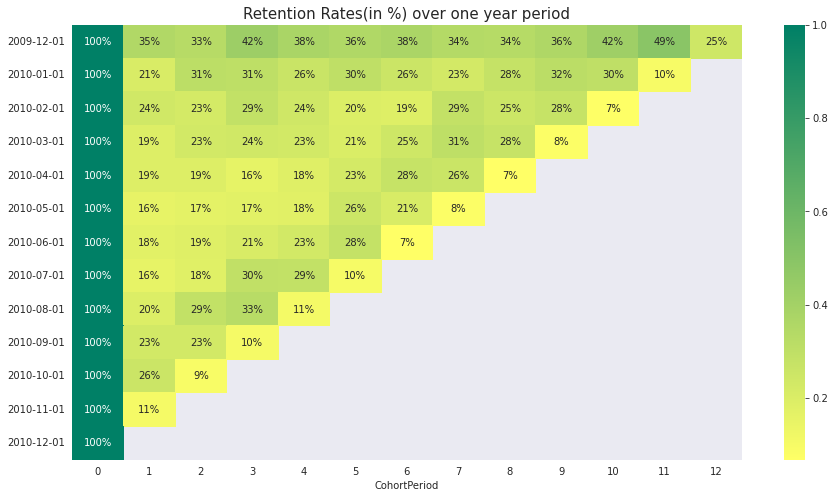

In [61]:
#Build the heatmap or pictorial representation of above table

plt.figure(figsize=(15, 8))
plt.title('Retention Rates(in %) over one year period', size=15)
sns.heatmap(data=retention, annot = True, fmt = '.0%', cmap="summer_r")
plt.show()

In [62]:
amount_cohort = df_cohort.pivot_table(index='CohortMonth', columns='CohortPeriod', values='Amount', aggfunc='mean').round(2)
amount_cohort

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2009-12-01,22.51,31.88,25.76,26.57,24.21,24.28,23.52,27.51,32.23,28.09,28.60,26.18,27.99
2010-01-01,16.85,21.67,16.25,19.83,21.45,23.54,21.10,18.59,21.65,20.37,21.77,21.52,NaN
2010-02-01,17.11,17.19,24.46,19.06,17.70,19.51,18.87,18.35,17.00,17.65,19.94,NaN,NaN
2010-03-01,16.75,21.46,18.79,19.40,17.83,18.77,20.26,17.55,18.06,22.06,NaN,NaN,NaN
2010-04-01,18.22,18.01,19.38,30.05,19.07,18.60,17.43,17.57,14.27,NaN,NaN,NaN,NaN
2010-05-01,17.30,17.38,17.98,17.72,23.79,15.47,13.93,10.28,NaN,NaN,NaN,NaN,NaN
2010-06-01,16.91,15.52,19.36,16.97,17.12,19.62,23.48,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,13.75,16.12,12.25,15.54,14.15,15.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,13.08,14.10,14.78,15.46,19.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
* The above table shows the average amount spent by the group of customers over the period of time.

* ex: For the group of customers of Jan'2011 they initially spent 16.85 but after one month they spent 21.67 higher than the previous, then they spend 16.25 after two months and so on.

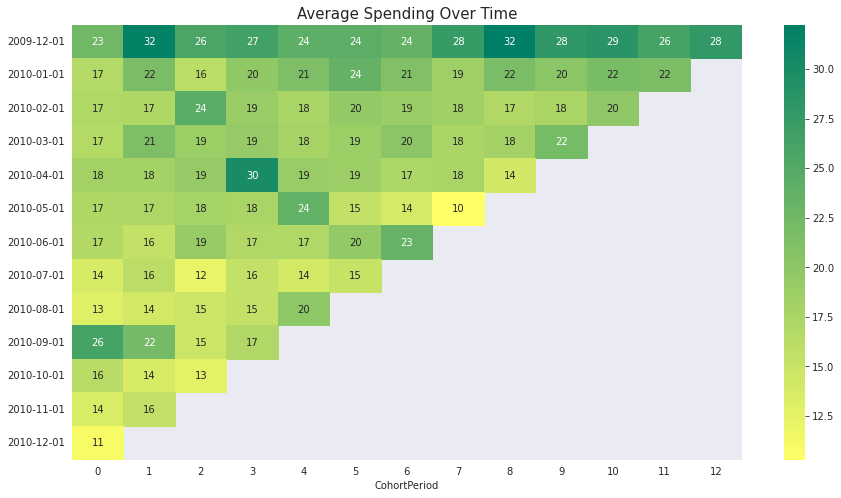

In [63]:
#Build the heatmap or pictorial representation of above table

amount_cohort.index = pd.to_datetime(amount_cohort.index).date
plt.figure(figsize=(15, 8))
plt.title('Average Spending Over Time', size=15)
sns.heatmap(data = amount_cohort, annot = True, cmap="summer_r")
plt.show()

### 2. RFM Analysis

* Recency: How much time has elapsed since a customer’s last activity or transaction with the brand? Activity is usually a purchase, although variations are sometimes used, e.g., the last visit to a website or use of a mobile app. In most cases, the more recently a customer has interacted or transacted with a brand, the more likely that customer will be responsive to communications from the brand.
* Frequency: How often has a customer transacted or interacted with the brand during a particular period of time? Clearly, customers with frequent activities are more engaged, and probably more loyal, than customers who rarely do so. And one-time-only customers are in a class of their own.
* Monetary: Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time. Big spenders should usually be treated differently than customers who spend little. Looking at monetary divided by frequency indicates the average purchase amount – an important secondary factor to consider when segmenting customers.

In [64]:
# copying the data in other df
df_rfm = df.copy()
# keeping only desired columns
df_rfm = df_rfm.iloc[:,:9]
df_rfm.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [65]:
# extracting the RECENCY

recency = pd.DataFrame(df_rfm.groupby('Customer ID')['InvoiceDate'].max().reset_index())
recency['InvoiceDate'] = pd.to_datetime(recency['InvoiceDate']).dt.date
recency['MaxDate'] = recency['InvoiceDate'].max()
recency['recency'] = (recency['MaxDate'] - recency['InvoiceDate']).dt.days + 1
recency = recency[['Customer ID','recency']]
recency.head()

,Customer ID,recency
0,12346.0,165
1,12347.0,3
2,12348.0,74
3,12349.0,43
4,12351.0,11


In [66]:
# extracting the FREQUENCY

frequency = pd.DataFrame(df_rfm.groupby('Customer ID')['Invoice'].nunique().reset_index())
frequency.columns = ['fCustomerID','frequency']
frequency.head()

,fCustomerID,frequency
0,12346.0,11
1,12347.0,2
2,12348.0,1
3,12349.0,3
4,12351.0,1


In [67]:
# extracting the MONETARY

monetary = pd.DataFrame(df_rfm.groupby('Customer ID')['Amount'].sum().reset_index())
monetary.columns = ['mCustomerID','monetary']
monetary.head()

,mCustomerID,monetary
0,12346.0,372.86
1,12347.0,1323.32
2,12348.0,222.16
3,12349.0,2671.14
4,12351.0,300.93


In [68]:
# combining the three into one table

rfm = pd.concat([recency,frequency,monetary], axis=1)
rfm.drop(['fCustomerID','mCustomerID'], axis=1, inplace=True)
rfm.head(10)

,Customer ID,recency,frequency,monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93
5,12352.0,11,2,343.80
6,12353.0,44,1,317.76
7,12355.0,203,1,488.21
8,12356.0,16,3,3560.30
9,12357.0,24,2,12079.99


In [69]:
# extracting SPEED OF VISIT

customer_list = list(df_rfm["Customer ID"].unique())
c = []
v = []
for ids in customer_list:
    sov = df_rfm[df_rfm['Customer ID']==ids].groupby('InvoiceDate')['Invoice'].count().reset_index()
    if sov.shape[0]>3:
        sov['InvoiceDate1'] = sov['InvoiceDate'].shift(1)
        sov['Difference'] = (sov['InvoiceDate']-sov['InvoiceDate1']).dt.days
        mean_days = round(sov.Difference.mean(),0)
        c.append(ids)
        v.append(mean_days)
    else:
        c.append(ids)
        v.append(0)
speed_of_visit = pd.DataFrame()
speed_of_visit['sCustomerID'] = c
speed_of_visit['sov'] = v
speed_of_visit = speed_of_visit.sort_values('sCustomerID').reset_index(drop=True)
speed_of_visit.head()

,sCustomerID,sov
0,12346.0,19.0
1,12347.0,0.0
2,12348.0,0.0
3,12349.0,0.0
4,12351.0,0.0


In [70]:
# checking the overall highlights. The number of distinct customers are 4334
rfm.info()# checking the summary
rfm.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  4300 non-null   float64
 1   recency      4300 non-null   int64  
 2   frequency    4300 non-null   int64  
 3   monetary     4300 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 134.5 KB


,Customer ID,recency,frequency,monetary
count,4300.000000,4300.000000,4300.000000,4300.000000
mean,15350.424651,91.268837,4.436047,2023.024154
std,1702.032144,97.098918,7.997083,8828.333816
min,12346.000000,1.000000,1.000000,0.000000
25%,13882.500000,18.000000,1.000000,306.525000
50%,15352.500000,52.000000,2.000000,700.405000
75%,16835.250000,136.000000,5.000000,1705.540000
90%,17692.200000,255.000000,9.000000,3735.697000
95%,17988.050000,304.050000,13.000000,6123.636500
99%,18231.030000,368.000000,31.010000,19960.795400


Approach:
* As we got RFM for each customer, now the objective is to label or categorize the customer into different category based upon their value.
* For this first we categorize the R,F,M values into the labels 1-5. 1 being the low and 5 being the higest. Here we make cuts at 25%, 50%, 75% and 90% to distribute them into 5 categories.
* After that we sum these values for each row and label the column 'score' which have values range from 3-15.
* After that we make cuts on 'score' at 25%, 50%, 75% and 90% to categorize the customers into Bad, Bronze, Silver, Gold and Platinum.
* These cuts can be done in many ways like by discussion with the client, according to expert advise, business understanding or quartiles cuts(which we did in this) etc.

In [71]:
# assigning the numbers to RFM values. The better the RFM value higher the number
# note that this process is reverse for R score as lower the value the better it is

rfm['recency_score'] = pd.cut(rfm['recency'], bins=[0,18,51,143,264,375], labels=[5,4,3,2,1])
rfm['recency_score'] = rfm['recency_score'].astype('int')
rfm['frequency_score'] = pd.cut(rfm['frequency'], bins=[0,1,2,5,9,210], labels=[1,2,3,4,5])
rfm['frequency_score'] = rfm['frequency_score'].astype('int')
rfm['monetary_score'] = pd.cut(rfm['monetary'], bins=[-1,306,667,1650,3614,290000], labels=[1,2,3,4,5])

rfm.dropna(inplace=True)

In [72]:
rfm['monetary_score'] = rfm['monetary_score'].astype('int')

In [73]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4299 entries, 0 to 4299
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer ID      4299 non-null   float64
 1   recency          4299 non-null   int64  
 2   frequency        4299 non-null   int64  
 3   monetary         4299 non-null   float64
 4   recency_score    4299 non-null   int64  
 5   frequency_score  4299 non-null   int64  
 6   monetary_score   4299 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 268.7 KB


In [74]:
# summing the R,F,M score to make a one single column that has value range from 3-15

def score_rfm(x) : return (x['recency_score']) + (x['frequency_score']) + (x['monetary_score'])
rfm['score'] = rfm.apply(score_rfm,axis=1 )
rfm.head()

,Customer ID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score
0,12346.0,165,11,372.86,2,5,2,9.0
1,12347.0,3,2,1323.32,5,2,3,10.0
2,12348.0,74,1,222.16,3,1,1,5.0
3,12349.0,43,3,2671.14,4,3,4,11.0
4,12351.0,11,1,300.93,5,1,1,7.0


In [75]:
rfm.score.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    4299.000000
mean        8.504769
std         3.282023
min         3.000000
25%         6.000000
50%         8.000000
75%        11.000000
90%        13.000000
95%        14.000000
99%        15.000000
max        15.000000
Name: score, dtype: float64

In [76]:
# assigning the customers into one of the category Bad, Bronze, Silver, Gold and Platinum based upon the score they get
# we make cuts using percentiles. It can be done in many other ways

rfm['customer_type'] = pd.cut(rfm['score'], bins=[0,6,8,11,13,16], labels=['Bad','Bronze','Silver','Gold','Platinum'])
rfm.head()

,Customer ID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,customer_type
0,12346.0,165,11,372.86,2,5,2,9.0,Silver
1,12347.0,3,2,1323.32,5,2,3,10.0,Silver
2,12348.0,74,1,222.16,3,1,1,5.0,Bad
3,12349.0,43,3,2671.14,4,3,4,11.0,Silver
4,12351.0,11,1,300.93,5,1,1,7.0,Bronze


In [77]:
round(rfm.customer_type.value_counts(normalize=True)*100,0)

Bad         32.0
Silver      28.0
Bronze      20.0
Gold        11.0
Platinum     9.0
Name: customer_type, dtype: float64

Observations:
* We see that around 9% of customers are in platinum category and these are the customers who score is best in all the three RFM. Combining with the gold 20% customers are those who are genuine and honest with the business.
* Silver category are those where the business can target to convert them into gold category by rolling out offers and new strategies for them.
* Bad category are those who are less concerned for the business and does not put much efforts to bring them back.

In [78]:
# looking the RFM value for each of the category
rfm.groupby('customer_type')['recency','frequency','monetary'].mean().round(0)


,recency,frequency,monetary
customer_type,,,
Bad,184.0,1.0,277.0
Bronze,80.0,2.0,649.0
Silver,48.0,4.0,1438.0
Gold,25.0,8.0,3035.0
Platinum,10.0,19.0,11160.0


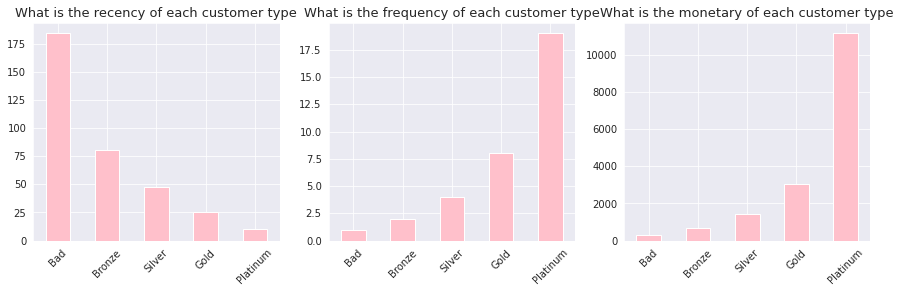

In [79]:
column = ['recency','frequency','monetary']
plt.figure(figsize=(15,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    rfm.groupby('customer_type')[j].mean().round(0).plot(kind='bar', color='pink')
    plt.title('What is the {} of each customer type'.format(j), size=13)
    plt.xlabel('')
    plt.xticks(rotation=45)

plt.show()

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:

* First we initialize k points, called means, randomly.
* We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
* We repeat the process for a given number of iterations and at the end, we have our clusters.

## 3. k-Means Clustering

In [80]:
# copying the data into new variable
df_kmeans = rfm.copy()
# taking only relevant columns
df_kmeans = df_kmeans.iloc[:,:4]
df_kmeans.head()

,Customer ID,recency,frequency,monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


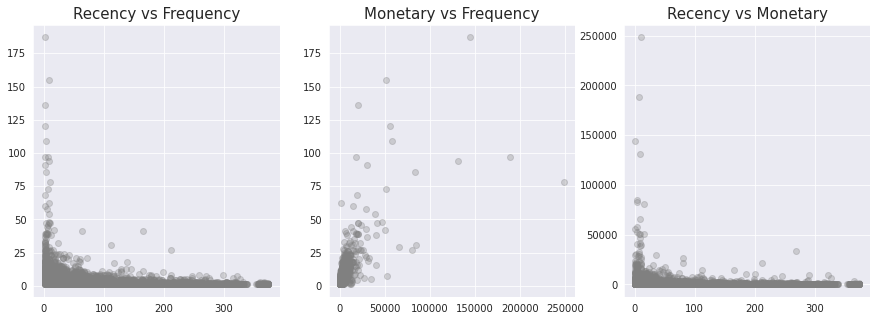

In [81]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df_kmeans.recency, df_kmeans.frequency, color='grey', alpha=0.3)
plt.title('Recency vs Frequency', size=15)
plt.subplot(1,3,2)
plt.scatter(df_kmeans.monetary, df_kmeans.frequency, color='grey', alpha=0.3)
plt.title('Monetary vs Frequency', size=15)
plt.subplot(1,3,3)
plt.scatter(df_kmeans.recency, df_kmeans.monetary, color='grey', alpha=0.3)
plt.title('Recency vs Monetary', size=15)
plt.show()

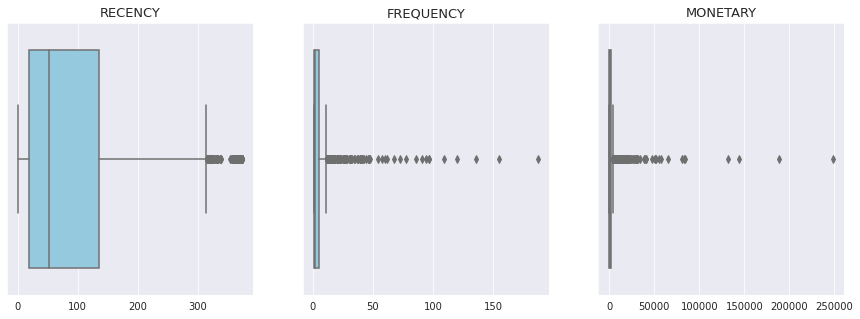

In [82]:
# checking the distribution of the variables

column = ['recency','frequency','monetary']
plt.figure(figsize=(15,5))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    sns.boxplot(df_kmeans[j], color='skyblue')
    plt.xlabel('')
    plt.title('{}'.format(j.upper()), size=13)
plt.show()

In [83]:
# Removing outliers for Monetary
Q1 = df_kmeans.monetary.quantile(0.05)
Q3 = df_kmeans.monetary.quantile(0.95)
IQR = Q3 - Q1
df_kmeans = df_kmeans[(df_kmeans.monetary >= Q1 - 1.5*IQR) & (df_kmeans.monetary <= Q3 + 1.5*IQR)]

# Removing outliers for Recency
Q1 = df_kmeans.recency.quantile(0.05)
Q3 = df_kmeans.recency.quantile(0.95)
IQR = Q3 - Q1
df_kmeans = df_kmeans[(df_kmeans.recency >= Q1 - 1.5*IQR) & (df_kmeans.recency <= Q3 + 1.5*IQR)]

# Removing outliers for Frequency
Q1 = df_kmeans.frequency.quantile(0.05)
Q3 = df_kmeans.frequency.quantile(0.95)
IQR = Q3 - Q1
df_kmeans = df_kmeans[(df_kmeans.frequency >= Q1 - 1.5*IQR) & (df_kmeans.frequency <= Q3 + 1.5*IQR)]

In [84]:
# resetting the index
df_kmeans = df_kmeans.reset_index(drop=True)
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4224 entries, 0 to 4223
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  4224 non-null   float64
 1   recency      4224 non-null   int64  
 2   frequency    4224 non-null   int64  
 3   monetary     4224 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 132.1 KB


In [85]:
# looking at random 5 rows
df_kmeans.sample(5)

,Customer ID,recency,frequency,monetary
589,13223.0,59,4,805.92
1347,14302.0,66,3,742.90
1181,14074.0,259,1,219.40
1583,14623.0,16,5,1130.28
2697,16175.0,107,3,798.85


In [86]:
# removing customer id as it will not used in making cluster
df_kmeans = df_kmeans.iloc[:,1:]

# scaling the variables and store it in different df
standard_scaler = StandardScaler()
df_kmeans_norm = standard_scaler.fit_transform(df_kmeans)

# converting it into dataframe
df_kmeans_norm = pd.DataFrame(df_kmeans_norm)
df_kmeans_norm.columns = ['recency','frequency','monetary']
df_kmeans_norm.head()

,recency,frequency,monetary
0,0.744639,1.916252,-0.530938
1,-0.920407,-0.452950,-0.020138
2,-0.190665,-0.716195,-0.611928
3,-0.509285,-0.189706,0.704213
4,-0.838183,-0.716195,-0.569595


* Initially without any knowledge we are clustering the data into 5 clusters. The only intution to do is as in RFM we categorize the data into 5 categories.
* Later we look different methods to decide the optimal value for k.

In [87]:
# Kmeans with K=5

model_clus5 = KMeans(n_clusters = 5)
model_clus5.fit(df_kmeans_norm)

KMeans(n_clusters=5)

In [88]:
# checking the labels
model_clus5.labels_

array([3, 1, 1, ..., 2, 1, 3], dtype=int32)

In [89]:
df_kmeans['clusters'] = model_clus5.labels_
df_kmeans.head()

,recency,frequency,monetary,clusters
0,165,11,372.86,3
1,3,2,1323.32,1
2,74,1,222.16,1
3,43,3,2671.14,3
4,11,1,300.93,1


In [90]:
df_kmeans.groupby('clusters').mean().round(0)

,recency,frequency,monetary
clusters,,,
0,25.0,11.0,4341.0
1,54.0,2.0,607.0
2,251.0,2.0,452.0
3,36.0,6.0,2026.0
4,30.0,15.0,9504.0


Finding the Optimal Number of Clusters


Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

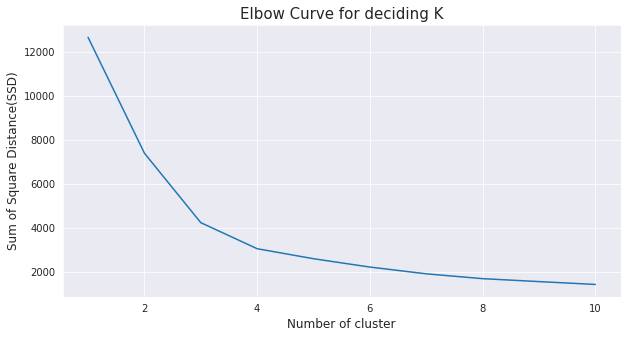

In [91]:
# Elbow-curve/SSD

ssd = []
for num_clusters in list(range(1,11)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_kmeans_norm)
    ssd.append(model_clus.inertia_)
    
# plot the SSDs for each n_clusters
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,11,1), ssd)
plt.xlabel('Number of cluster', size=12)
plt.ylabel('Sum of Square Distance(SSD)', size=12)
plt.title('Elbow Curve for deciding K', size=15)
plt.show()

In [92]:
# Silhouette analysis

for num_clusters in list(range(2,11)):
    # intialise kmeans
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_kmeans_norm)
    
    cluster_labels = model_clus.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_kmeans_norm, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5293456062629296
For n_clusters=3, the silhouette score is 0.5069189629891666
For n_clusters=4, the silhouette score is 0.48561951234024764
For n_clusters=5, the silhouette score is 0.4373324553829841
For n_clusters=6, the silhouette score is 0.4122172412384529
For n_clusters=7, the silhouette score is 0.41612802988106434
For n_clusters=8, the silhouette score is 0.38633034188256693
For n_clusters=9, the silhouette score is 0.3518285496619462
For n_clusters=10, the silhouette score is 0.35693274241406237


* From the elbow curve we observe the elbow at cluster 3 and cluster 4.
* Also from Silhouette analysis we see the value is better when number of cluster will be 3 rather than 4.
* So we now categorize the data into 3 clusters and check their RFM values and its distribution.

In [93]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3)
model_clus3.fit(df_kmeans_norm)

KMeans(n_clusters=3)

In [94]:
df_kmeans['clusters'] = model_clus3.labels_
df_kmeans.head()

,recency,frequency,monetary,clusters
0,165,11,372.86,0
1,3,2,1323.32,0
2,74,1,222.16,0
3,43,3,2671.14,0
4,11,1,300.93,0


In [95]:
df_kmeans.groupby('clusters').mean().round(0)

,recency,frequency,monetary
clusters,,,
0,48.0,3.0,1000.0
1,246.0,2.0,450.0
2,26.0,12.0,5357.0


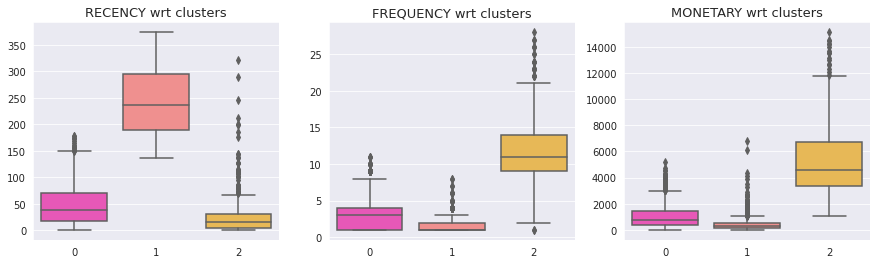

In [96]:
column = ['recency','frequency','monetary']
plt.figure(figsize=(15,4))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=df_kmeans[j], x=df_kmeans['clusters'], palette='spring')
    plt.title('{} wrt clusters'.format(j.upper()), size=13)
    plt.ylabel('')
    plt.xlabel('')

plt.show()

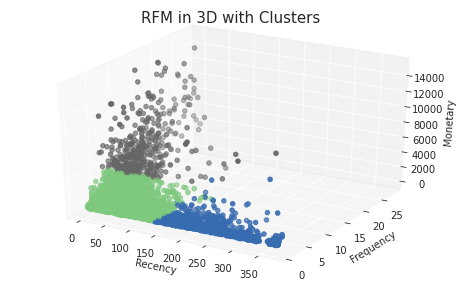

In [97]:
# Creating figure
fig = plt.figure(figsize = (8, 5))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(df_kmeans.recency, df_kmeans.frequency, df_kmeans.monetary, c=df_kmeans.clusters, cmap='Accent')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('RFM in 3D with Clusters', size=15)
ax.set(facecolor='white')
plt.show()

Observations:
* In the above 3D graph, I put all the three variable into 3 axis and added the cluster variable to differentiate the points.
* Grey points is the group of customers whose Recency is high, Frequency is low and Monetary value is also low.
* Green points are the group of customers whose Recency is low, Frequency is better than grey ones and Monetary is good.
* Blue points are the group of customers whose Recency is low(that is good), Frequency is better than the other two and Monetary is high.